# Large Language Encoder Models

In this tutorial you will explore the Transformer encoder model delving into the **self-attention mechanism**.


## Imports and definitions

In [2]:
import numpy as np
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')



In [3]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))


# Bidirectional Encoder Representations Transformers

There are many models that build on top of the Bidirection Encoder Representations Transformer architecture (**BERT**). The HuggingFace repository of models the standard place where you can find models for a wide range of tasks. These are stable models that were made available by researchers and the industry.

   https://huggingface.co/models

The example below is a popular BERT model. It uses a cross-encoder trained on the Next Sentence Prediction task and Masked Language Model task. It is fine-tuned on the MSMARCO dataset as a retrieval model.

   https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/ce-msmarco.md


In [4]:
model_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
model_path = 'nboost/pt-bert-base-uncased-msmarco'
CLS_token = "[CLS]"
SEP_token = "[SEP]"

The Transformer encoder is loaded in two parts:
 - **Tokenizer:** First, you need to load the corresponding tokenizer. This will pre-process the input text and split it into tokens.
 - **Model:** Second, the model should be loaded according to a predefined configuration. The model will then assign a embedding to each token and process the entire input sequentially throughout the entire set of layers. 

In [5]:
transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

After loading the model, you can inspect its architecture. Tipycally, each model is composed by the embedding layer, the self-attention layers and the output layers. The output layer is always task specific. 

In [6]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Next Sentence Prediction 

## Tokenization

See here for details: https://huggingface.co/docs/transformers/tokenizer_summary

In [7]:
sentence_a = ["How many people live in Berlin?", "How many people live in Berlin?"]
sentence_b =  ["Berlin has a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers.", "New York City is famous for the Metropolitan Museum of Art."]
#inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)

pprint.pprint(inputs)

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101,  2129,  2116,  2111,  2444,  1999,  4068,  1029,   102,  4068,
          2038,  1037,  2313,  1997,  1017,  1010, 19611,  1010,  6021,  2487,
          5068,  4864,  1999,  2019,  2181,  1997,  6486,  2487,  1012,  6445,
          2675,  7338,  1012,   102],
        [  101,  2129,  2116,  2111,  2444,  1999,  4068,  1029,   102,  2047,
          2259,  2103,  2003,  3297,  2005,  1996,  4956,  2688,  1997,  2396,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0

In [8]:
print(tokenizer.decode(inputs["input_ids"][0].tolist()))
print(tokenizer.decode(inputs["input_ids"][1].tolist()))


[CLS] how many people live in berlin? [SEP] berlin has a population of 3, 520, 031 registered inhabitants in an area of 891. 82 square kilometers. [SEP]
[CLS] how many people live in berlin? [SEP] new york city is famous for the metropolitan museum of art. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [9]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
pprint.pprint(input_id_list)

[101,
 2129,
 2116,
 2111,
 2444,
 1999,
 4068,
 1029,
 102,
 4068,
 2038,
 1037,
 2313,
 1997,
 1017,
 1010,
 19611,
 1010,
 6021,
 2487,
 5068,
 4864,
 1999,
 2019,
 2181,
 1997,
 6486,
 2487,
 1012,
 6445,
 2675,
 7338,
 1012,
 102]


In [10]:
input_tokens_list = tokenizer.convert_ids_to_tokens(input_id_list)
pprint.pprint(input_tokens_list)

['[CLS]',
 'how',
 'many',
 'people',
 'live',
 'in',
 'berlin',
 '?',
 '[SEP]',
 'berlin',
 'has',
 'a',
 'population',
 'of',
 '3',
 ',',
 '520',
 ',',
 '03',
 '##1',
 'registered',
 'inhabitants',
 'in',
 'an',
 'area',
 'of',
 '89',
 '##1',
 '.',
 '82',
 'square',
 'kilometers',
 '.',
 '[SEP]']


In [11]:
#inputs = tokenizer(sentence_a, sentence_b, return_offsets_mapping = True, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)


In [12]:
inputs

{'input_ids': tensor([[  101,  2129,  2116,  2111,  2444,  1999,  4068,  1029,   102,  4068,
          2038,  1037,  2313,  1997,  1017,  1010, 19611,  1010,  6021,  2487,
          5068,  4864,  1999,  2019,  2181,  1997,  6486,  2487,  1012,  6445,
          2675,  7338,  1012,   102],
        [  101,  2129,  2116,  2111,  2444,  1999,  4068,  1029,   102,  2047,
          2259,  2103,  2003,  3297,  2005,  1996,  4956,  2688,  1997,  2396,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 

In [13]:
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(input_id_list, input_tokens_list))
print(res)

101 	 [CLS]
2129 	 how
2116 	 many
2111 	 people
2444 	 live
1999 	 in
4068 	 berlin
1029 	 ?
102 	 [SEP]
4068 	 berlin
2038 	 has
1037 	 a
2313 	 population
1997 	 of
1017 	 3
1010 	 ,
19611 	 520
1010 	 ,
6021 	 03
2487 	 ##1
5068 	 registered
4864 	 inhabitants
1999 	 in
2019 	 an
2181 	 area
1997 	 of
6486 	 89
2487 	 ##1
1012 	 .
6445 	 82
2675 	 square
7338 	 kilometers
1012 	 .
102 	 [SEP]


## Model inference

In [14]:
with torch.no_grad():
    outputs = model(**inputs)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [15]:
outputs.keys()

odict_keys(['logits', 'hidden_states', 'attentions'])

## Hidden layer embeddings

In [16]:
# total number of layers embeddings
len(outputs['hidden_states'])

13

In [17]:
# The format is as follow:
# outputs['hidden_states'][layer_m][0][token_n]
layer_m = 12
token_n = 1
# Get all the embeddings of one layer:
output_embeddings = outputs['hidden_states'][layer_m][0]
output_embeddings.shape

torch.Size([34, 768])

In [18]:
token_throat = 2
token_cancer = 3

# Get the embedding of one particular token in one particular layer
throat_output_embedding = outputs['hidden_states'][layer_m][0][token_throat]
throat_output_embedding.shape

torch.Size([768])

In [19]:
output_embeddings.shape

torch.Size([34, 768])

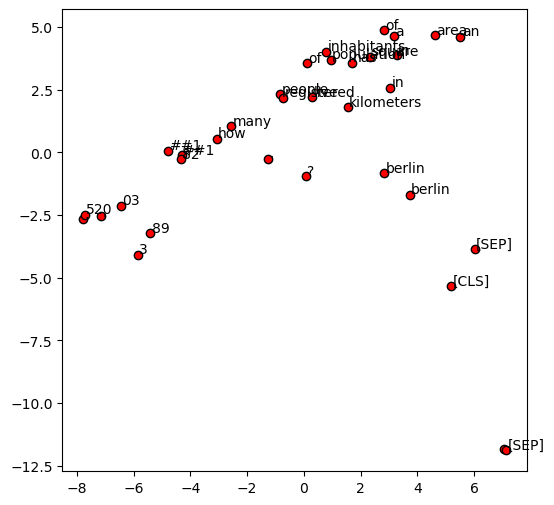

In [20]:
def display_scatterplot(data, words):

    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(output_embeddings.detach().numpy())
        twodim = pca.transform(data)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return

display_scatterplot(output_embeddings.detach().numpy(), input_tokens_list)

## Extract contextual word embeddings



In [21]:
import re

def get_word_idx(sent: str, word: str):
    tmp_lst = re.split(r' |\?|\.',sentence_a)
    return tmp_lst.index(word)

def get_word_vector(inputs, outputs, idx, layer):
    """Get a word vector by averaging the embeddings of 
       all word occurrences of that word in the input"""

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == idx)
    print(inputs.word_ids())
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]
    print(token_ids_word)
    return word_tokens_output.mean(dim=0)

# The code below converts the tokens into a space delimited string.
# This will allow computing in which position of the BERT input sequence a given word is.
sentence_a = tokenizer.decode(inputs["input_ids"][0].tolist()).replace("[CLS] ", '').replace(" [SEP]", '')
word = "berlin"
idx = get_word_idx(sentence_a, word)
print(idx)
print("Input sequence:", sentence_a)
print("The word \"", word, "\" occurs in position", idx, "of the BERT input sequence.")

word_embedding = get_word_vector(inputs, outputs, idx, 4)


5
Input sequence: how many people live in berlin? berlin has a population of 3, 520, 031 registered inhabitants in an area of 891. 82 square kilometers.
The word " berlin " occurs in position 5 of the BERT input sequence.
[None, 0, 1, 2, 3, 4, 5, 6, None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 16, 17, 18, 19, 20, 21, None]
(array([ 6, 14]),)


In [22]:
import torch
import re
from transformers import AutoTokenizer, AutoModel

def get_word_vector_from_ab(inputs, outputs, word, layer = '-1', ab = 'A'):
    """
    This method extracts a word embedding from the requested layer 
    for sentence_a or sentence_b. If the word is divided into tokens, 
    the word embedding will be the average of the corresponding token 
    embeddings.

    NOTE: If the same word occurs multiple times in the sentence, 
    this method returns the word embedding of the first occurrence.

    Keyword arguments:
        inputs -- input passed to the transformer
        outputs -- output of the transformer
        word -- target word
        layer -- layer from where the word embedding vector should 
        be extracted.
        ab -- should be 'A' or 'B' indication if the word embedding is to be extracted 
        from sentence_a or sentence_b, i.e., query or document.
    """
       
    sep_token = np.where(np.array(inputs["input_ids"][0].tolist()) == 102)[0][0]
    if ab == 'A':
        tokens_a = inputs["input_ids"][0][1:sep_token]
        sent = tokenizer.decode(tokens_a.tolist())
    else:
        tokens_b = inputs["input_ids"][0][sep_token+1:-1]
        sent = tokenizer.decode(tokens_b.tolist())

    print(sent)
    word_ids = get_word_idx(sent, word)

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == word_ids)[0]
    sep_word = np.where(np.array(inputs.word_ids()) == None)[0][1]

    if ab == 'A':
        token_pos = token_ids_word < sep_word
    else:
        token_pos = token_ids_word > sep_word
        
    token_ids_word = token_ids_word[token_pos]
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]

    # Change this to True for inspection
    details = True
    if details:
        input_id_list = input_ids[0].tolist() # Batch index 0
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        str1 = " "

        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
        print("INPUT SEQUENCE TOKENS: ", str1.join(tokens))
        print("TARGET WORD:", word)
        print("TARGET SENTENCE:", ab)
        print("TARGET SENTENCE WORDS [", sent, "]")
        print("The word [", word, "] occurs in position", idx, "of the BERT input sentence", ab)
        print("The word [", word, "] corresponds to the token(s)", token_ids_word, "of the BERT input sequence", ab)

    return word_tokens_output.mean(dim=0)


word_embedding = get_word_vector_from_ab(inputs, outputs, "berlin", 4, 'A')


how many people live in berlin?
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INPUT SEQUENCE TOKENS:  [CLS] how many people live in berlin ? [SEP] berlin has a population of 3 , 520 , 03 ##1 registered inhabitants in an area of 89 ##1 . 82 square kilometers . [SEP]
TARGET WORD: berlin
TARGET SENTENCE: A
TARGET SENTENCE WORDS [ how many people live in berlin? ]
The word [ berlin ] occurs in position 5 of the BERT input sentence A
The word [ berlin ] corresponds to the token(s) [6] of the BERT input sequence A


In [23]:
word_embedding.size()

torch.Size([768])

## Self-attention matrices

In [24]:
attention = outputs['attentions']

# The format of the attention tensor is:
#     attention[layer][sample_n][head][token1][token2]

layer = 3      # Transformer layer
sample_n = 1   # Input sample
head = 3       # Head of the selected layer

In [25]:
# the score of the attention of one token vs the other token
attention[layer][sample_n][head][token_throat][token_cancer]

tensor(0.0226)

In [26]:
attention[layer][sample_n][head].size()

torch.Size([34, 34])

In [27]:
# There's a softmax, so, the sum should be 1 
attention[layer][sample_n][head][token_throat].sum()

tensor(1.0000)

In [28]:
attention[layer][sample_n][head][token_cancer].sum()

tensor(1.)

# Exercises

 1. Examine the model architecture depicted below identify the number of tokens, embeddings dimensions, position embeddings, number of layers, number of heads,  etc.
 2. Draw the architecture of this Transformer encoder.

In [29]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e